<a href="https://colab.research.google.com/github/batyaSchechter/Humor_generation/blob/main/Humor_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#open ai api and load constraint file

In [ ]:
# Install and initialize the OpenAI Python client with an API key
!pip install openai

from openai import OpenAI

client = OpenAI(api_key="XXX")


In [ ]:
def get_from_open_AI(prompt):
    """
    Sends a prompt to the OpenAI chat model and returns the generated response.
    :param prompt: input prompt (str)
    :return: Model response content (str)
    """
    response = client.chat.completions.create(
    model="gpt-5.1",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
    ]
   )

    return(response.choices[0].message.content)

In [ ]:
#Competition dataset loading
import pandas as pd

file_path = '/content/task-a-en.tsv'
df = pd.read_csv(file_path, sep='\t')

print(df.head())

        id word1 word2                                           headline
0  en_2001     -     -  Panamanian lawmakers’ Taiwan trip sparks diplo...
1  en_2002     -     -  Carra: Liverpool must sign in January - even a...
2  en_2003     -     -  Experts warn of health threat posed by ultra-p...
3  en_2004     -     -  Dick Cheney funeral: George W. Bush delivers e...
4  en_2005     -     -  No place for Mostert distraction in South Afri...


#Shared Experimental Utilities

In [ ]:
# Create a table for storing jokes for evaluation
humor_evaluation_table = pd.DataFrame(
    columns=["id","constraint_type","constraint", "humor_style", "method", "joke"]
)


In [ ]:
def get_constraint_for_prompt(word1, word2,headline):
   """
    Generates a textual constraint for a joke-generation prompt,
    either based on a headline or on required words.
    """
   if word1=='-':
      return f'that related to the headline: "{headline}"'
   else:# include words constraint
      return f'that naturally includes the words "{word1}" and "{word2}"'

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load sentence embedding model for semantic similarity checks
model = SentenceTransformer("all-MiniLM-L6-v2")

def check_constraint(word1,word2,headline,joke):
     """
    Checks whether a joke satisfies the given constraint:
    either by containing specific words or by being semantically
    related to the headline using cosine similarity.
    """
     if word1!='-':
        return word1 in joke and word2 in joke
     else:
        embeddings = model.encode([headline, joke])
        similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
        return similarity >= 0.6

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from pathlib import Path
import pandas as pd

def append_row_to_csv(new_row):
    """
    Appends a single-joke to a CSV file.
    Creates the file (with header) if it doesn't exist.
    """
    p = Path('/content/drive/MyDrive/Humor generation/jenerated jockes.csv')
    p.parent.mkdir(parents=True, exist_ok=True)

    file_exists = p.exists()

    new_row.to_csv(
        p,
        mode="a",                 # append
        header=not file_exists,   # header only if the file is new
        index=False,
        encoding="utf-8"
    )

In [ ]:

def generate_valid_joke_row(row,prompt,h_type,method):

    #Generates a joke using the LLM and retries until it satisfies the given constraint,
    #then returns a single-row DataFrame ready to be appended to the evaluation table.

   word1 = row['word1']
   word2 = row['word2']
   joke_id=row["id"]
   headline = row["headline"]
   retry_count=0
   while True:
      joke_text = get_from_open_AI(prompt)
      if check_constraint(word1,word2,headline,joke_text):
        new_row = pd.DataFrame([{
        "id": joke_id,
        "constraint_type": 'words' if word1 !='-' else 'headline',
        "constraint":  f'{word1}, {word2}' if word1 !='-' else headline,
        "humor_style": h_type,
        "method": method,
        "joke": joke_text}])
        append_row_to_csv(new_row)
        return new_row

      else:
        retry_count+=1
        #print(f"retry {retry_count}")
        if retry_count>3:
          #print(f'fail to generate valid joke for constraint id{joke_id}')
          error_row = pd.DataFrame([{
          "id": joke_id,
          "constraint_type": 'words' if word1 !='-' else 'headline',
          "constraint":  f'{word1}, {word2}' if word1 !='-' else headline,
          "humor_style": h_type,
          "method": method,
          "joke": "faild!"}])
          append_row_to_csv(error_row)
          return



In [ ]:
humor_types = [
    "Wordplay", "Irony", "Incongruity", "Absurd",
    "Observational", "Self-deprecating", "Social",
    "Logical twist", "Dark humor", "Wholesome"
]

#Zero shot

In [ ]:
# Generate jokes for each constraint using multiple humor styles (zero-shot prompting)
from httpx import head


for index, row in df.iterrows():
   word1 = row['word1']
   word2 = row['word2']
   headline = row["headline"]

   for h_type in humor_types:
      # Construct a zero-shot prompt with a humor style and constraint
      prompt =f'''You are a humor writer. Write one short, funny joke, {h_type} style ,{get_constraint_for_prompt(word1,word2,headline)}.The joke should be coherent, sound natural, and make sense in context.
                It must include both words exactly as given. (1–3 sentences). Make sure it's a complete joke with a punchline.
               Output only the joke.'''

      new_row = generate_valid_joke_row(row,prompt,h_type,'Zero shot')

      # Append the generated joke to the evaluation table
      humor_evaluation_table = pd.concat(
      [humor_evaluation_table, new_row],
      ignore_index=True
      )


#few shots

In [ ]:
# Few-shot examples grouped by humor style, used to guide the model's generation

humor_examples = [
    [
        "Wordplay",
        "I wondered why the baseball was getting bigger. Then it hit me.",
        "I’m reading a book on anti-gravity. It’s impossible to put down."
    ],
    [
        "Irony",
        "I love deadlines. I especially like the whooshing sound they make as they fly by.",
        "I’m on a seafood diet. I see food… and I eat it."
    ],
    [
        "Incongruity",
        "I tried to take a selfie with my fridge, but it didn’t say cheese.",
        "My dog chased a squirrel up a tree. Too bad it was a plastic tree in the mall."
    ],
    [
        "Absurd",
        "I told my toothbrush we were breaking up. It couldn’t handle the plaque in our relationship.",
        "A duck walked into a pharmacy and bought lip balm. 'Put it on my bill,' it said."
    ],
    [
        "Observational",
        "Isn’t it weird how we talk to babies in a higher voice… even when the baby is a dog?",
        "You never realize how many people you dislike until you have to name your Wi-Fi."
    ],
    [
        "Self-deprecating",
        "I don’t need a hairdresser. My pillow gives me a new hairstyle every morning.",
        "My fitness coach told me to 'touch my toes.' I said, 'If they wanted to be touched, they wouldn’t be so far away.'"
    ],
    [
        "Social",
        "We now have smart TVs, smart cars, smart fridges… I miss when only people were dumb.",
        "Group projects taught me one thing: some people were born to ride, not to drive."
    ],
    [
        "Logical twist",
        "I told my friend I broke my arm in two places. He said, 'Stop going to those places.'",
        "The doctor told me I needed more exercise, so I started sleeping on the other side of the bed for variety."
    ],
    [
        "Dark humor",
        "My therapist says I have pre-traumatic stress disorder. I’m stressed about things that will probably happen.",
        "I told my skeleton friend he was too thin. He took it personally."
    ],
    [
        "Wholesome",
        "I asked my grandma for a bookmark. She smiled and said, 'Honey, I’ve been calling you that for years.'",
        "My dog loves when I read aloud. I think he likes that I finally speak his language: 'woof woof.'"
    ]
]


In [ ]:
# Generate jokes using few-shot prompting by providing example jokes per humor style

for index, row in df.iterrows():
  word1 = row['word1']
  word2 = row['word2']
  headline=row["headline"]
  for h_type,ex1,ex2 in humor_examples:
    # Construct a few-shot prompt with humor style examples and constraints
    prompt =f'''You are a humor writer. Write one short, funny joke, {h_type} style ,{get_constraint_for_prompt(word1,word2,headline)}.The joke should be coherent, sound natural, and make sense in context.
                It must include both words exactly as given. (1–3 sentences). Make sure it's a complete joke with a punchline. example to {h_type} jokes: 1: {ex1} 2: {ex2}
               Output only the joke.'''
    new_row = generate_valid_joke_row(row,prompt,h_type,'few shots')
    # Append the generated joke to the evaluation table
    humor_evaluation_table = pd.concat([humor_evaluation_table, new_row], ignore_index=True )

#cot

In [ ]:

# Generate jokes using chain-of-thought prompting

for index, row in df.iterrows():
  word1 = row['word1']
  word2 = row['word2']
  headline=row["headline"]
  for h_type in humor_types:
     # Construct a CoT-style prompt to guide internal reasoning
    prompt =f'''Write a joke {get_constraint_for_prompt(word1,word2,headline)} in the humor style: {h_type}.
First, use chain-of-thought reasoning:
1. Identify what makes this humor style funny.
2. Describe the structure of a typical joke in this style.
3. Brainstorm 3 possible directions for the joke.
4. Choose the strongest idea and explain why.
Then, write the final joke in one short sentence.
Do NOT include the  chain-of-thought reasoning in the final answer.'''

    new_row = generate_valid_joke_row(row,prompt,h_type,'cot')
    # Append the generated joke to the evaluation table
    humor_evaluation_table = pd.concat([humor_evaluation_table, new_row], ignore_index=True )

#Incongruity / Semantic contrast

In [ ]:

from sentence_transformers import SentenceTransformer, util
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

model = SentenceTransformer("all-mpnet-base-v2")

def split_setup_punchline(joke_text):
    sentences = nltk.sent_tokenize(joke_text)

    # if there is only 2 sentences
    if len(sentences) == 2:
        return sentences[0], sentences[1]

    embeddings = model.encode(sentences, convert_to_tensor=True)

    # similarity matrix
    sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

    # For each sentence, we take the average of its similarity with all the other sentences
    avg_similarity = sim_matrix.mean(axis=1)

    # The sentence with the lowest similarity is the punchline
    punch_index = np.argmin(avg_similarity)

    punchline = sentences[punch_index]
    setup = " ".join([s for i, s in enumerate(sentences) if i != punch_index])

    return setup, punchline

def incongruity_score(joke_text):
    setup, punchline = split_setup_punchline(joke_text)

    # Encode only the setup and the punchline
    emb_setup, emb_punch = model.encode([setup, punchline], convert_to_tensor=True)

    # Cosine similarity between the setup and the punchline
    sim = util.cos_sim(emb_setup, emb_punch).item()

    # Incongruity = 1 - similarity (the larger it is, the greater the semantic contrast).
    return 1 - sim #, setup, punchline






[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Compute semantic incongruity scores for each joke and normalize them to [0, 1]
humor_evaluation_table["semantic_contrast_score"] = \
    humor_evaluation_table["joke"].apply(incongruity_score)
humor_evaluation_table.head(50)
col = "semantic_contrast_score"

min_val = humor_evaluation_table[col].min()
max_val = humor_evaluation_table[col].max()

# Min-max normalization of the semantic contrast scores
humor_evaluation_table[col] = (
    (humor_evaluation_table[col] - min_val) / (max_val - min_val)
)

#Emotion / Humor potential

In [ ]:
# Load a pretrained emotion classification model and initialize an emotion analysis pipeline

!pip install transformers torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "SamLowe/roberta-base-go_emotions"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

emotion_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    truncation=True
)

def get_emotions(text):
  # Returns emotion labels and their confidence scores for a given text.

    outputs = emotion_classifier(text)[0]
    return {o['label']: o['score'] for o in outputs}


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Emotions associated with humorous content
import numpy as np

EMOTIONS = ["surprise", "amusement"]

def humor_potential_score(text):
    emotions = get_emotions(text)

    # Sum of selected positive emotion scores
    score = sum(emotions.get(e, 0.0) for e in EMOTIONS)
    return  score

# Compute humor potential scores for all generated jokes
humor_evaluation_table["humor_potential_score"] = (
    humor_evaluation_table["joke"].apply(humor_potential_score)
)

#joke = "never write with a broken penciel because it is pointless."
#result = humor_potential_score(joke)
#print(result)



You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


#Irony / Sarcasm

In [ ]:

!pip install transformers torch

In [ ]:
# Load a pretrained irony detection model and initialize an irony classification pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_name = "cardiffnlp/twitter-roberta-base-irony"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

irony_classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    truncation=True
)


config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def irony_score(text: str):
   #    Computes an irony score for the given text using a pretrained irony classifier.
    outputs = irony_classifier(text)[0]
    probs = {o["label"]: o["score"] for o in outputs}
    prob_irony =  probs.get("LABEL_1", 0.0)


    return probs.get("irony")

In [ ]:
# Compute irony scores for all generated jokes
humor_evaluation_table["irony_score"] = (
    humor_evaluation_table["joke"].apply(irony_score)
)

#ex1 = "never write with a broken penciel because it is pointless."
#ex2 = "I'm really happy we finished the project on time."

#print(irony_score(ex1))
#print(irony_score(ex2))


#Fluency / Readability

In [ ]:
# Load GPT-2 language model for fluency evaluation via perplexity
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import math

# Load model
model_name = "gpt2"  # or gpt2-medium
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

def calculate_perplexity(text):
   #    Computes the perplexity of a given text as a measure of linguistic fluency.
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids

    with torch.no_grad():
        output = model(input_ids, labels=input_ids)
        loss = output.loss

    ppl = math.exp(loss.item())
    return ppl

# Example:
#joke = "I tried to spray my chair with confidence, but it just leaned to the side and scoffed."
#print("PPL:", calculate_perplexity(joke))


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 90dd5b70-cb9d-480e-a1d4-04bde4a11ab1)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/merges.txt
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ed32d379-0924-4b5d-b061-c776fdaf42c9)')' thrown while requesting GET https://huggingface.co/gpt2/resolve/main/merges.txt
Retrying in 1s [Retry 1/5].


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 414dbea2-34c3-4169-b581-34d1221fb62b)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/tokenizer.json
Retrying in 1s [Retry 1/5].


tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 1d28321c-fc55-4420-acd8-6711c0248e90)')' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/special_tokens_map.json
Retrying in 1s [Retry 1/5].


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# Compute fluency/readability score as the negative perplexity (lower perplexity indicates better fluency)
humor_evaluation_table["Fluency_Readability_score"] =-1*(
    humor_evaluation_table["joke"].apply(calculate_perplexity)
)



`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


#originality

In [ ]:
pip install sentence-transformers faiss-cpu pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 42.3 MB/s eta 0:00:00


In [ ]:
#do not run again - use next section to load embeddings file that created by this section

# Generate and store sentence embeddings for a large jokes corpus
# Used for semantic analysis (e.g., incongruity / contrast estimation)
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import os

DATA_PATH = "shortjokes.csv"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"


EMB_PATH = "/content/drive/MyDrive/shortjokes_embeddings.npy"
TEXT_PATH = "/content/drive/MyDrive/shortjokes_texts.npy"


df = pd.read_csv(DATA_PATH, engine='python', on_bad_lines='skip')



if "Joke" in df.columns:
    text_col = "Joke"
else:
    text_col = df.columns[0]

jokes = df[text_col].astype(str).fillna("").tolist()

print(f"Loaded {len(jokes)} jokes from {DATA_PATH}")
print("Loading SentenceTransformer model...")
model = SentenceTransformer(MODEL_NAME)

# create embeddings
print("Encoding jokes to embeddings...")
embeddings = model.encode(
    jokes,
    convert_to_numpy=True,
    show_progress_bar=True
).astype("float32")

# copy to file in drive
os.makedirs(os.path.dirname(EMB_PATH), exist_ok=True)
np.save(EMB_PATH, embeddings)
np.save(TEXT_PATH, np.array(jokes, dtype=object))

print(f"Saved embeddings to: {EMB_PATH}")
print(f"Saved jokes text to: {TEXT_PATH}")


'#do not run\n#Generating embeddings for the jokes corpus\nimport pandas as pd\nimport numpy as np\nfrom sentence_transformers import SentenceTransformer\nimport os\n\nDATA_PATH = "shortjokes.csv"  \nMODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"\n\n\nEMB_PATH = "/content/drive/MyDrive/shortjokes_embeddings.npy"\nTEXT_PATH = "/content/drive/MyDrive/shortjokes_texts.npy"\n\n\ndf = pd.read_csv(DATA_PATH, engine=\'python\', on_bad_lines=\'skip\')\n\n\n\nif "Joke" in df.columns:\n    text_col = "Joke"\nelse:\n    text_col = df.columns[0]\n\njokes = df[text_col].astype(str).fillna("").tolist()\n\nprint(f"Loaded {len(jokes)} jokes from {DATA_PATH}")\nprint("Loading SentenceTransformer model...")\nmodel = SentenceTransformer(MODEL_NAME)\n\n# create embeddings\nprint("Encoding jokes to embeddings...")\nembeddings = model.encode(\n    jokes,\n    convert_to_numpy=True,\n    show_progress_bar=True\n).astype("float32")\n\n# copy to file in drive\nos.makedirs(os.path.dirname(EMB_PATH), exis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer


# Paths for embedding file

EMB_PATH = "/content/drive/MyDrive/Humor generation/shortjokes_embeddings.npy"
TEXT_PATH = "/content/drive/MyDrive/Humor generation/shortjokes_texts.npy"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

#load embedding file
print("Loading ShortJokes embeddings...")
embeddings = np.load(EMB_PATH)           # shape = (N, D)
jokes_texts = np.load(TEXT_PATH, allow_pickle=True)  # shape = (N,)

print(f"Loaded {len(jokes_texts)} jokes with embeddings of size {embeddings.shape}")

#load embedding model
print("Loading embedding model...")
model = SentenceTransformer(MODEL_NAME)


#calculate cosine similarity
def cosine_similarity_matrix(vec, mat):

    vec_norm = vec / (np.linalg.norm(vec) + 1e-8)
    mat_norm = mat / (np.linalg.norm(mat, axis=1, keepdims=True) + 1e-8)
    sims = mat_norm @ vec_norm     # dot product row-wise
    return sims


#fine most similar jokes
def most_similar_jokes(new_joke_text, top_k=5):
    # create embeddin to new joke
    new_emb = model.encode(new_joke_text, convert_to_numpy=True).astype("float32")

    # Similarity against the entire dataset
    sims = cosine_similarity_matrix(new_emb, embeddings)

    #select Top-K
    top_idx = np.argsort(-sims)[:top_k]

    return [
        {
            "index": int(idx),
            "similarity": float(sims[idx]),
            "joke": jokes_texts[idx]
        }
        for idx in top_idx
    ]





Loading ShortJokes embeddings...
Loaded 231657 jokes with embeddings of size (231657, 384)
Loading embedding model...


In [ ]:
# Compute novelty scores based on semantic similarity to the most similar jokes
humor_evaluation_table["Movelty_score"] = None
for idx, row in humor_evaluation_table.iterrows():
    results = most_similar_jokes(row["joke"], top_k=5)
    mean_sim = np.mean([r["similarity"] for r in results])
     # Novelty is defined as inverse mean similarity
    humor_evaluation_table.at[idx, "Movelty_score"] = 1 - mean_sim

#calculate score

In [ ]:
 #Applies min–max normalization to a score column in the evaluation table.

def normalize_score(col):
    min_val = humor_evaluation_table[col].min()
    max_val = humor_evaluation_table[col].max()

    # to prevent divide by zero
    if max_val == min_val:
        humor_evaluation_table[col] = 0
        return

    humor_evaluation_table[col] = (
        (humor_evaluation_table[col] - min_val) / (max_val - min_val)
    )

In [ ]:
# Normalize all score columns to [0, 1], excluding the final weighted score
for col in humor_evaluation_table.columns:
    if col.endswith('_score') and col != 'weighted_funny_score':
        normalize_score(col)

In [ ]:
#delete faild generations and ensuring that each constraint received a sufficient number of generations.
humor_evaluation_table=humor_evaluation_table[humor_evaluation_table['joke']!='faild!']
humor_evaluation_table.value_counts('id' ,ascending=True)

,count
id,
en_2259,19
en_2033,19
en_2209,20
en_2040,23
en_2186,23
...,...
en_2297,30
en_2298,30
en_2299,30


In [ ]:
# Define weights for each evaluation metric in the final humor score
WEIGHTS = {
    "semantic_contrast_score": 0.35,  # Incongruity
    "humor_potential_score":  0.25,   # Emotion / humor potential
    "Movelty_score":          0.15,   # Novelty
    "Fluency_Readability_score": 0.15,# Fluency / readability
    "irony_score":            0.10,   # Irony
}
# Compute a weighted aggregate humor score for each joke
humor_evaluation_table["weighted_funny_score"] = (
    WEIGHTS["semantic_contrast_score"]   * humor_evaluation_table["semantic_contrast_score"] +
    WEIGHTS["humor_potential_score"]     * humor_evaluation_table["humor_potential_score"] +
    WEIGHTS["Movelty_score"]             * humor_evaluation_table["Movelty_score"] +
    WEIGHTS["Fluency_Readability_score"] * humor_evaluation_table["Fluency_Readability_score"] +
    WEIGHTS["irony_score"]               * humor_evaluation_table["irony_score"]
)


#Best Joke Selection and import to csv

In [ ]:
# Select the highest-scoring joke per constraint based on the weighted humor score
best_rows = (
    humor_evaluation_table
    .sort_values("weighted_funny_score", ascending=False)
    .groupby("id", as_index=False)
    .first()
)

In [ ]:
from pathlib import Path
import pandas as pd
results_file_path = Path('/content/drive/MyDrive/Humor generation/results_file.csv')
results_file_path.parent.mkdir(parents=True, exist_ok=True)

file_exists = results_file_path.exists()

best_rows[['id','joke']].to_csv(
        results_file_path,
        mode="a",                 # append
        header=not file_exists,   # header only if the file is new
        index=False,
        encoding="utf-8"
    )

#Results Analysis

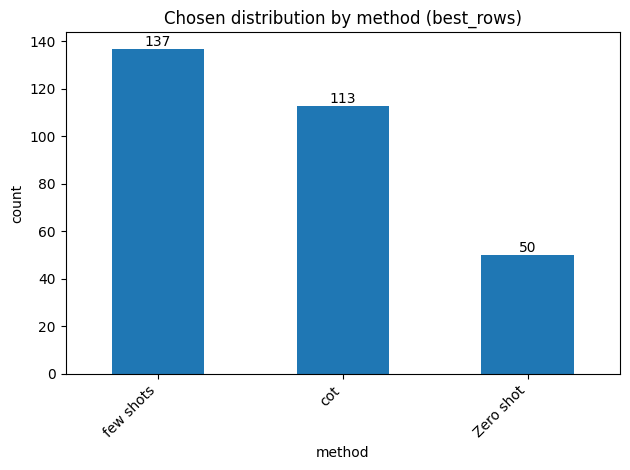

In [ ]:
# Visualize which generation method is selected most often in best_rows (winner-takes-all per id).
import matplotlib.pyplot as plt

method_counts = best_rows["method"].value_counts()

plt.figure()
ax = method_counts.plot(kind="bar")
plt.title("Chosen distribution by method (best_rows)")
plt.xlabel("method")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")

# add counts on bars
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()


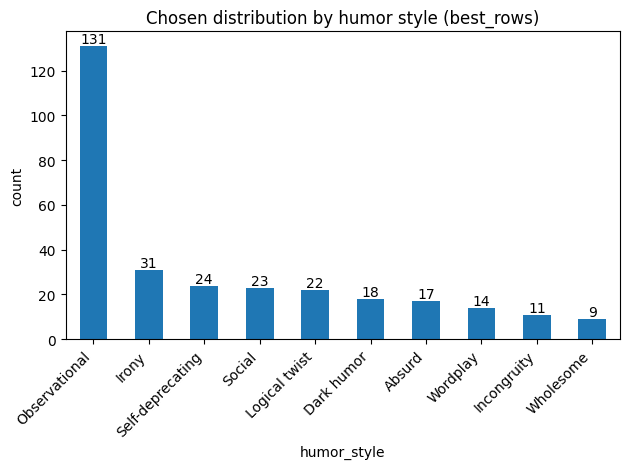

In [ ]:
# Visualize which humor_style is selected most often in best_rows (winner-takes-all per id).

style_counts = best_rows["humor_style"].value_counts()

plt.figure()
ax = style_counts.plot(kind="bar")
plt.title("Chosen distribution by humor style (best_rows)")
plt.xlabel("humor_style")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")

# add counts on bars
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()